In [1]:
import geopandas as gpd
import pandas as pd
import yaml
from rasterio.crs import CRS
from pathlib import Path
import fiona
from shapely.ops import polygonize
from shapely.geometry import mapping, Polygon, shape

In [2]:
yaml_file = '../events/yajiang_fire_2024.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'yajiang_fire_2024',
 'bounds': [100.96162212, 30.03892945, 101.33076217, 30.23238956],
 'event_date': '2024-03-15',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [26, 135],
 'mgrs_tiles': ['47RQP', '47RPP'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange',
 'links': ['https://data.humdata.org/dataset/the-wildfire-area-of-yajiang-country-sichuan-province-china via SDGSAT-1 MSI - March 3 and March 19',
  'https://www.rfa.org/english/news/tibet/sichuan-wildfires-03182024171046.html']}

In [15]:
fiona.listlayers('../external_validation_data/unosat/yajiang_fire/YajiangWildfireArea.gdb/')

['BurnArea_of_SichuanWildfire']

In [4]:
df_event = gpd.read_file('../external_validation_data/unosat/yajiang_fire/YajiangWildfireArea.gdb/', layer='BurnArea_of_SichuanWildfire')
df_event = df_event.to_crs(4326)
df_event.head()

,FID_BurnAr,Id,area,country,adm1,adm2,Shape_Length,geometry
0,20,1,0.983799,china,sichuan,yajiang,7988.152585,"MULTILINESTRING ((101.06769 30.05566, 101.0649..."
1,21,1,0.483550,china,sichuan,yajiang,4542.290599,"MULTILINESTRING ((101.05103 30.06223, 101.0496..."
2,14,1,0.588643,china,sichuan,yajiang,6873.531396,"MULTILINESTRING ((101.21657 30.11180, 101.2200..."
3,7,-1,0.022049,china,sichuan,yajiang,642.880457,"MULTILINESTRING ((101.26192 30.12477, 101.2621..."
4,1,-1,0.461122,china,sichuan,yajiang,3432.253495,"MULTILINESTRING ((101.04677 30.12737, 101.0501..."


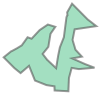

In [5]:
Polygon(*[geo.coords[:] for geo in df_event.geometry[0].geoms])

In [6]:
# inspired by https://stackoverflow.com/a/61684298
polys = [Polygon(*[geo.coords[:] for geo in multi_geo.geoms]) for multi_geo in df_event.geometry.tolist()]

In [7]:
df_event_f = df_event.copy()
df_event_f['geometry'] = polys

<Axes: >

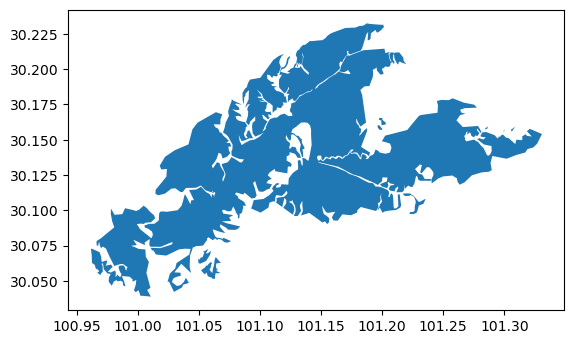

In [8]:
df_event_f.plot()

In [10]:
df_event_f.total_bounds

array([100.96162212,  30.03892945, 101.33076217,  30.23238956])

In [11]:
n = df_event_f.shape[0]
df_event_f = gpd.GeoDataFrame({'name': [event_dict['event_name'] for k in range(n)],
                               'date': [pd.to_datetime(event_dict['event_date']) for k in range(n)],
                               'source_id': [f'{event_dict["source_id"]}' for k in range(n)]},
                              geometry=df_event_f.geometry.tolist(),
                              crs=CRS.from_epsg(4326))
df_event_f.head()

,name,date,source_id,geometry
0,yajiang_fire_2024,2024-03-15,UNOSAT via humanitarian data exchange,"POLYGON ((101.06769 30.05566, 101.06494 30.055..."
1,yajiang_fire_2024,2024-03-15,UNOSAT via humanitarian data exchange,"POLYGON ((101.05103 30.06223, 101.04967 30.062..."
2,yajiang_fire_2024,2024-03-15,UNOSAT via humanitarian data exchange,"POLYGON ((101.21657 30.11180, 101.22008 30.112..."
3,yajiang_fire_2024,2024-03-15,UNOSAT via humanitarian data exchange,"POLYGON ((101.26192 30.12477, 101.26217 30.124..."
4,yajiang_fire_2024,2024-03-15,UNOSAT via humanitarian data exchange,"POLYGON ((101.04677 30.12737, 101.05013 30.127..."


In [12]:
EXTERNAL_VAL_DATA_DIR = Path('../external_validation_data_db/')
EXTERNAL_VAL_DATA_DIR.mkdir(exist_ok=True, parents=True)

In [13]:
#df_event_f.to_parquet(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.parquet')

In [14]:
df_event_f.to_file(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')

# Extents    

In [28]:
from shapely import convex_hull 
burn_geo = df_event_f.geometry.unary_union
hull_buffered = convex_hull(burn_geo).buffer(.025)
df_aoi = gpd.GeoDataFrame(geometry=[hull_buffered], crs=CRS.from_epsg(4326))
df_aoi['provenance'] = 'convex hull of burn area with .025 deg buffer'
df_aoi

,geometry,provenance
0,"POLYGON ((101.01498 30.01431, 101.01199 30.013...",convex hull of burn area with .025 deg buffer


<Axes: >

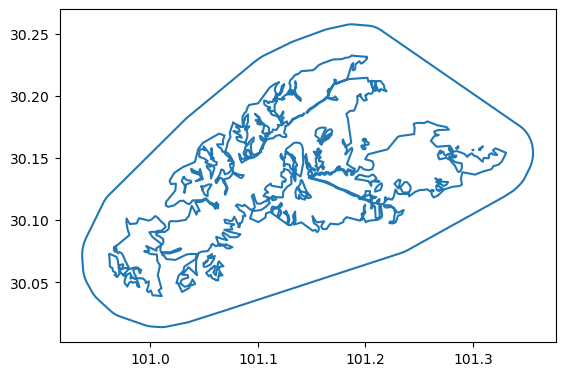

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df_aoi.boundary.plot(ax=ax)
df_event.plot(ax=ax)

In [30]:
EXTERNAL_VAL_EXTENTS = Path('../external_validation_data_extents_db/')
EXTERNAL_VAL_EXTENTS.mkdir(exist_ok=True, parents=True)

df_aoi.to_file(EXTERNAL_VAL_EXTENTS / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')